In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
import os
from os.path import join
import xarray as xr

import time
import copy 
import datetime

import sys  
sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.preprocessing import preprocess

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

# vol = '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/'
vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

In [96]:
xar = xr.open_dataset(vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

In [69]:
xar

<xarray.Dataset>
Dimensions:      (time: 2606)
Dimensions without coordinates: time
Data variables:
    base_time    datetime64[ns] ...
    time_offset  (time) datetime64[ns] ...
    pres         (time) float32 976.8 974.7 973.0 971.6 ... 29.6 29.5 29.5 29.4
    qc_pres      (time) int32 ...
    tdry         (time) float32 4.6 5.2 5.6 6.0 6.4 ... -56.0 -56.0 -55.9 -55.9
    qc_tdry      (time) int32 ...
    dp           (time) float32 0.6 0.0 -0.7 -1.2 ... -83.9 -83.9 -83.8 -83.8
    qc_dp        (time) int32 ...
    wspd         (time) float32 ...
    qc_wspd      (time) int32 ...
    deg          (time) float32 ...
    qc_deg       (time) int32 ...
    rh           (time) float32 ...
    qc_rh        (time) int32 ...
    u_wind       (time) float32 ...
    qc_u_wind    (time) int32 ...
    v_wind       (time) float32 ...
    qc_v_wind    (time) int32 ...
    wstat        (time) float32 ...
    asc          (time) float32 ...
    qc_asc       (time) int32 ...
    lat          (time) float32 ...
    lon          (time) float32 ...
    alt          (time) float32 ...
Attributes:
    qc_method:                    Standard Mentor QC
    Mentor_QC_Field_Information:  For each qc_<field> interpret the values as...
    mqc_software:                 $Id: mentorQC_main.c,v 1.36 2001/03/29 13:2...
    proc_level:                   b1
    ingest_software:               sonde_ingest.c,v 5.10 2001/03/21 01:13:08 ...
    input_source:                 a1 file generated from: sonde1:/data/collec...
    site_id:                      sgp
    facility_id:                  C1 : Central_Facility
    sample_int:                   1.2 seconds
    averaging_int:                None.
    resolution_description:       The resolution field attributes refer to th...
    phase_fitting_2:              
    phase_fitting_3:              
    pressure_correction:          
    temperature_correction:       
    humidity_correction:          
    launch_mode:                  Nominal Mode
    pressure_gc_sonde:            
    temperature_gc_sonde:         
    humidity_gc_sonde:            
    latitude_calculation:         lat[k-1]+((v_wind[k]-v_wind[k-1])/2)*delta_...
    longitude_calculation:        lon[k-1]+((u_wind[k]-u_wind[k-1])/2)*delta_...
    sonde_pc_software_version:    8.29
    phase_fitting_1:              Phase fitting length is  60 s from   0 min ...
    sounding_number:              100401013
    serial_number:                044251107
    launch_status:                \n100401013 SGP/CART/CF/MW15
\n74646
\n0104...
    comment:                      The time assigned to each data point indica...
    zeb_platform:                 sgpsondewnpnC1.b1
    history:                      created by the Zebra DataStore library, 1-A...

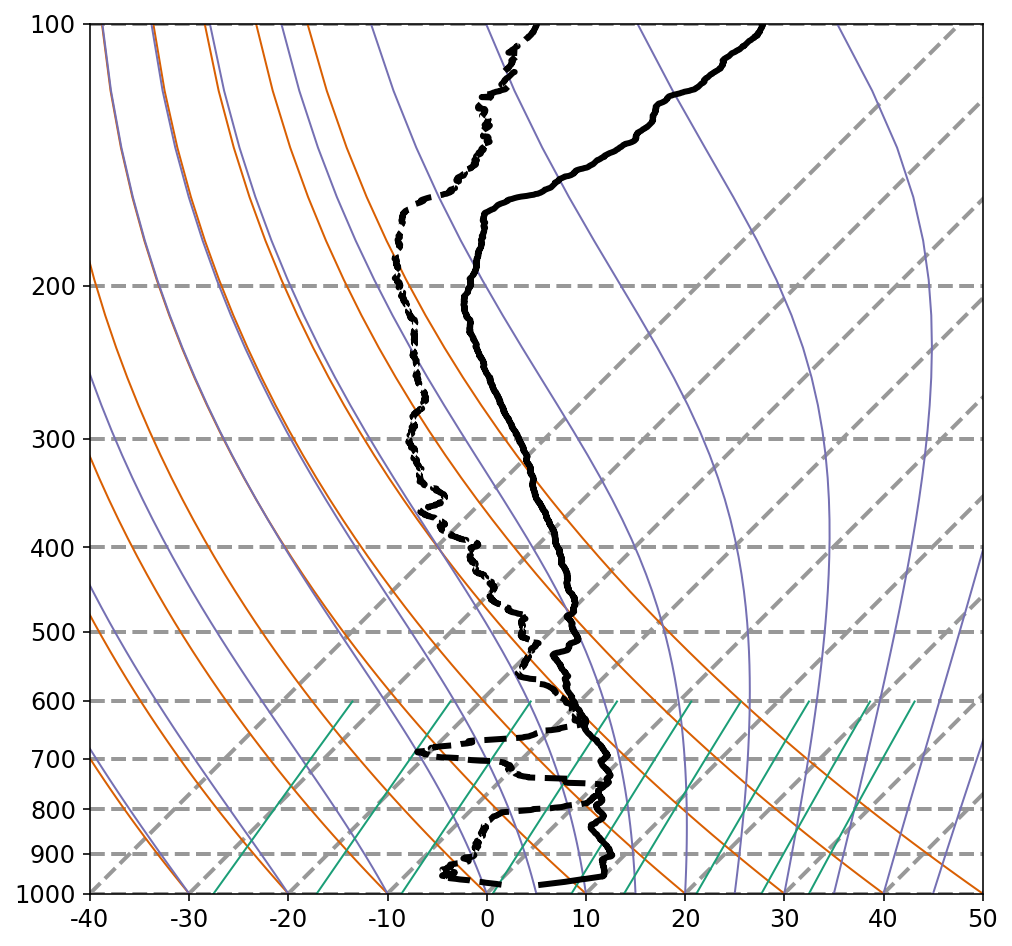

In [72]:
sounding_dict_for_metpy = dict()

sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = p
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = t
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = td

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy)
plt.show()

In [7]:
SONDE_PROFILE_DIMS = 2000
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= SONDE_PROFILE_DIMS and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

def plot_results(nnet, X, T, index=0):
    
    sounding_dict_for_metpy = dict()

    if len(X.shape) > 2:
        P = X[index,:,PRESSURE]
    else:
        P = X[index,:SONDE_PROFILE_DIMS]

    sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = P
    sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = T[index,:]
    sounding_dict_for_metpy[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(X[index:index+1,:])[0]

    radiosonde_plotting.plot_predicted_sounding(sounding_dict_for_metpy)
    
    fig, ax = plt.subplots(1, figsize=(8, 4))

    ax.plot(nnet.history['loss'], label='train')
    ax.plot(nnet.history['val_loss'], label='val')
    ax.legend();

time: 16.695, avg: 0.016 seconds
2001: 874/1037 are valid


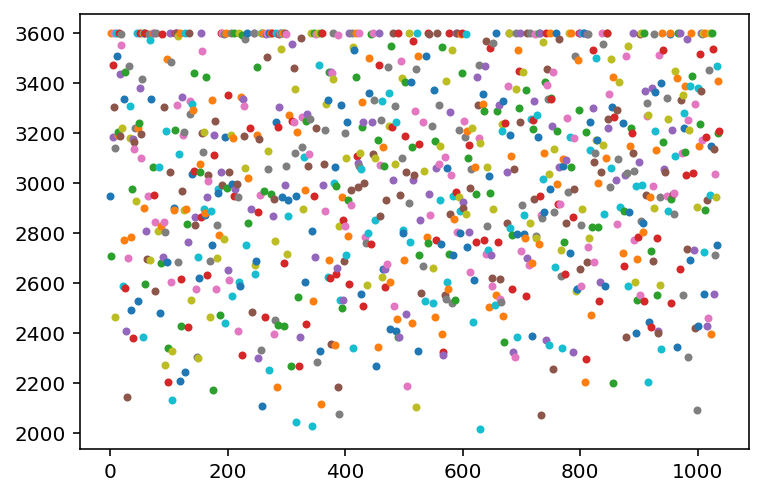

In [12]:
for year in range(2001, 2002): # 2021
    files = np.array(glob(join(vol, str(year), f'sgpsondewnpnC1.b1.*.cdf')))
    is_valid = np.ones(files.size, dtype=bool)
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        if valid_raob(xar):
            plt.plot(i, xar.pres.values.size, '.')
        else:
            is_valid[i] = False
        xar.close()
    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
    print(f'{year}: {np.where(is_valid == True)[0].size}/{files.size} are valid')

In [14]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

# Samples, (Pressure, Temperature, Dewpoint), Pressure Dims
profiles = np.zeros((files.size, 3, SONDE_PROFILE_DIMS))
is_valid = np.ones(files.size, dtype=bool)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        p = preprocess.interpolate_profile(xar.pres.values, SONDE_PROFILE_DIMS)
        t = preprocess.interpolate_profile(xar.tdry.values, SONDE_PROFILE_DIMS)
        td = preprocess.interpolate_profile(xar.dp.values, SONDE_PROFILE_DIMS)
        profiles[i] = np.concatenate(([p], [t], [td]))
    else:
        is_valid[i] = False        
    xar.close()    
e = time.time() - s

profiles = profiles[np.where(is_valid)[0]]

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
print(f': {np.where(is_valid == True)[0].size}/{files.size} are valid')

time: 416.507, avg: 0.015 seconds
: 24589/27209 are valid


In [ ]:
np.save('/s/chopin/l/grad/stock/data/soundings/raobs/profiles.npy', profiles)

In [4]:
profiles = np.load(vol + '../profiles.npy')

In [5]:
profiles.shape

(24589, 3, 2000)

## Set GPU (Incompatible on CS)

In [10]:
gpus = tf.config.list_physical_devices('XLA_GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'XLA_GPU')
        logical_gpus = tf.config.list_logical_devices('XLA_GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 0 Logical GPU


In [25]:
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [11]:
!nvidia-smi

Fri Jul 10 11:29:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 32%   72C    P2    75W / 250W |   1029MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Fully Connected NN

In [19]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, input_dims, :]
Xtrain = Xtrain.reshape((-1, Xtrain[0,:].size))
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = Xtest[:, input_dims, :]
Xtest = Xtest.reshape((-1, Xtest[0,:].size))
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 6000), (19671, 2000), (4918, 6000), (4918, 2000))

In [28]:
# 176 s
nnet = nn.NeuralNetwork(Xtrain.shape[1], [512, 256, 128, 256, 512], Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 25, 64, method='adam', verbose=True, 
           learning_rate=0.005, validation=[Xtest, Ttest])

epoch: 0, loss: 0.21868
epoch: 5, loss: 0.08301
epoch: 10, loss: 0.07301
epoch: 15, loss: 0.06841
epoch: 20, loss: 0.06474
epoch: 24, loss: 0.06029
finished!


NeuralNetwork(6000, [512, 256, 128, 256, 512], 2000)
  Final objective value is 0.06029 in 117.1774 seconds.

In [56]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024 

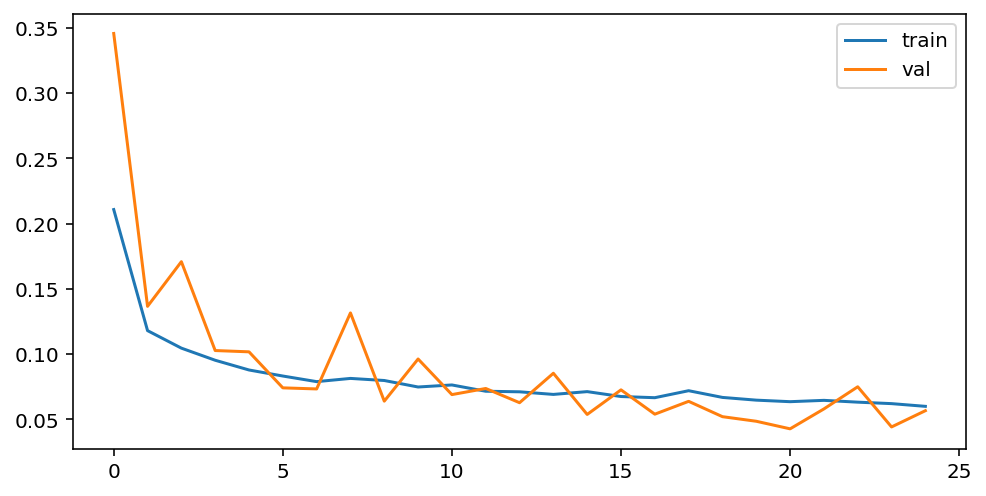

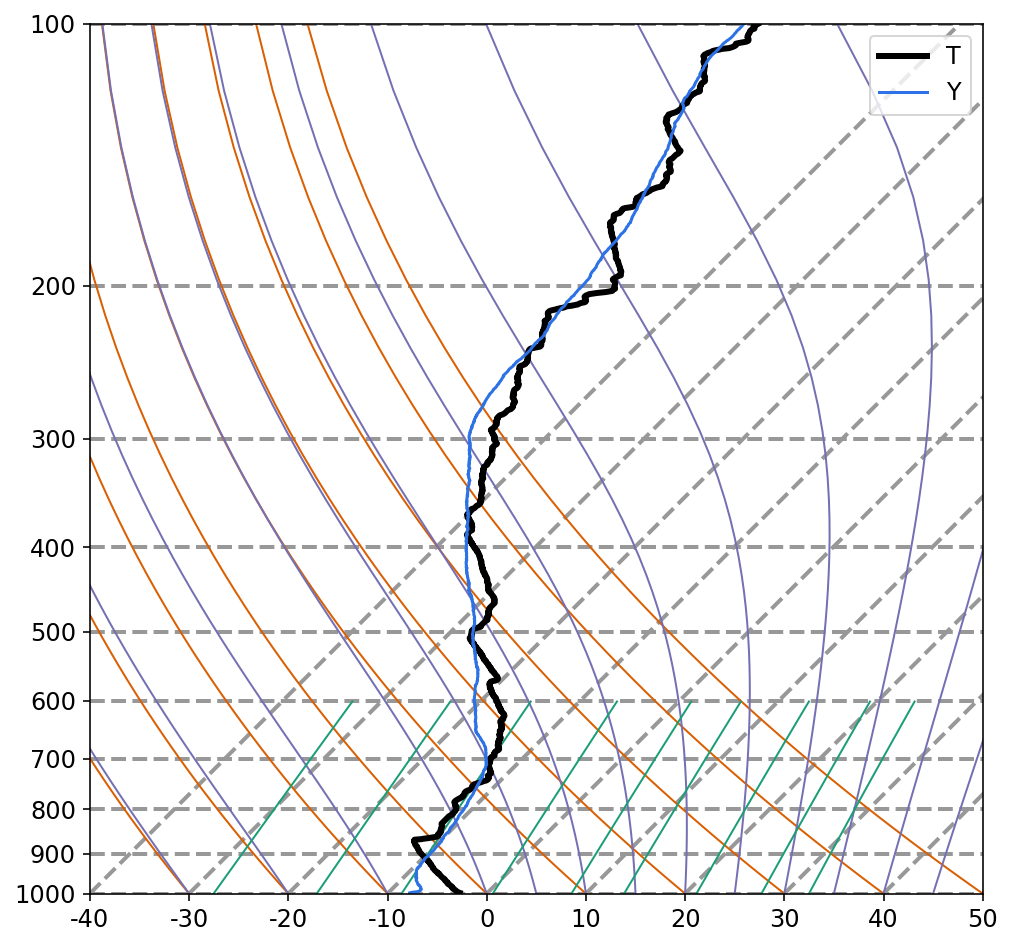

In [71]:
plot_results(nnet, Xtest, Ttest, index=0)

## Convolutional NN

In [8]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [9]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(10, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 10, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.44282
epoch: 5, loss: 0.01010
epoch: 9, loss: 0.00727
finished!


ConvolutionalNeuralNetwork((2000, 3), [3, 3, 3, 3], [(10, 1), (10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00727 in 70.9142 seconds.

In [10]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 3)           93        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 3)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 3)           93        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 3)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 3)            93        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 3)            0     

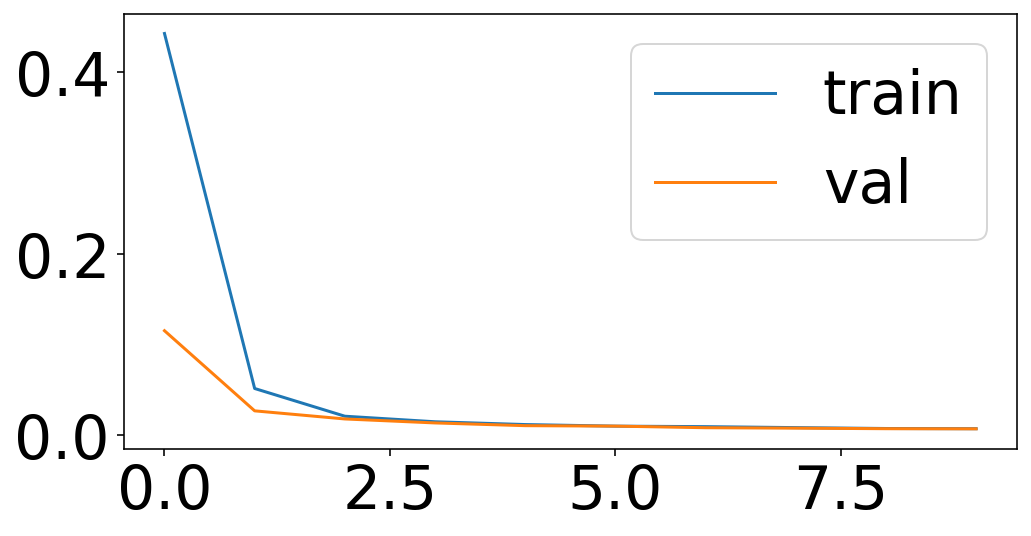

In [103]:
plot_results(nnet, Xtest, Ttest, index=22)

In [37]:
error = np.abs((nnet.use(Xtest) - Ttest))

pressures = Xtest[:,:,PRESSURE]
# Create linearly spaced bins from the min to max 
bins = np.linspace(pressures.min(), pressures.max(), SONDE_PROFILE_DIMS)
# Indicies of where which bin pressure values belong
pressure_bin_indicies = np.digitize(pressures, bins)
pressure_bin_indicies

array([[1957, 1953, 1950, ...,   35,   35,   35],
       [1945, 1943, 1940, ...,   35,   35,   35],
       [1955, 1951, 1949, ...,   33,   33,   33],
       ...,
       [1928, 1925, 1921, ...,   47,   47,   47],
       [1952, 1950, 1947, ...,   37,   37,   37],
       [1929, 1924, 1920, ...,   39,   39,   39]])

In [38]:
pressures[:,0].mean(), pressures[:,0].std()

(978.314981132467, 7.210629473269175)

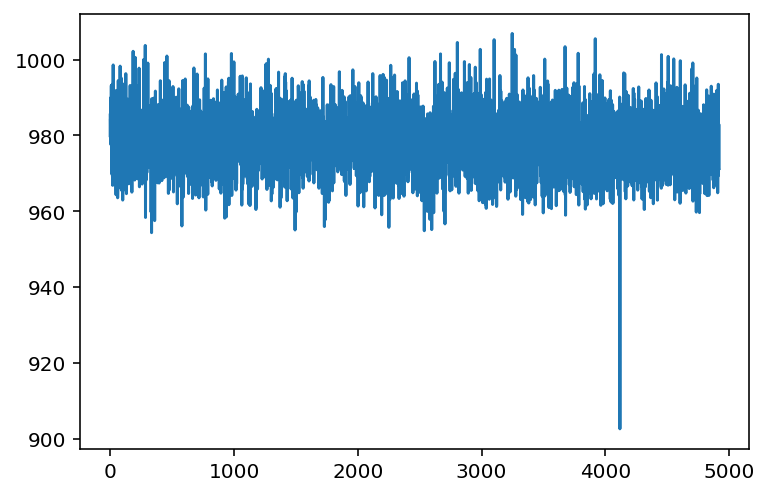

In [39]:
plt.plot(pressures[:,0])

In [40]:
mean_error = np.zeros(bins.size)
# Mean error corresponding to each bin of pressure levels
for bin_index in range(bins.size):
    vals = error[pressure_bin_indicies == bin_index]
    mean = np.mean(vals) if vals.size > 0 else 0
    mean_error[bin_index] = mean

In [45]:
# trim mean 0's from ends.

s = 0
for i in range(mean_error.size):
    if mean_error[i] != 0:
        s = i
        break
e = mean_error.size
for i in range(mean_error.size-1, 0, -1):
    if mean_error[i] != 0:
        e = i
        break
        
mean_error = mean_error[s:e+1]
bins = bins[s:e+1]

In [46]:
mean_error.shape

(1997,)

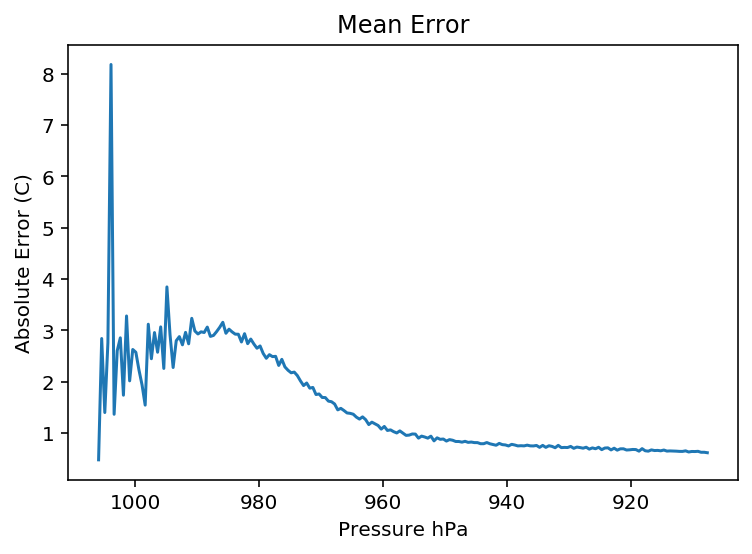

In [53]:
plt.plot(bins[1800:], mean_error[1800:])
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');

In [50]:
mean_error.mean()

0.5210661634312911

In [54]:
error.mean(axis=0)

0.39500628774614505

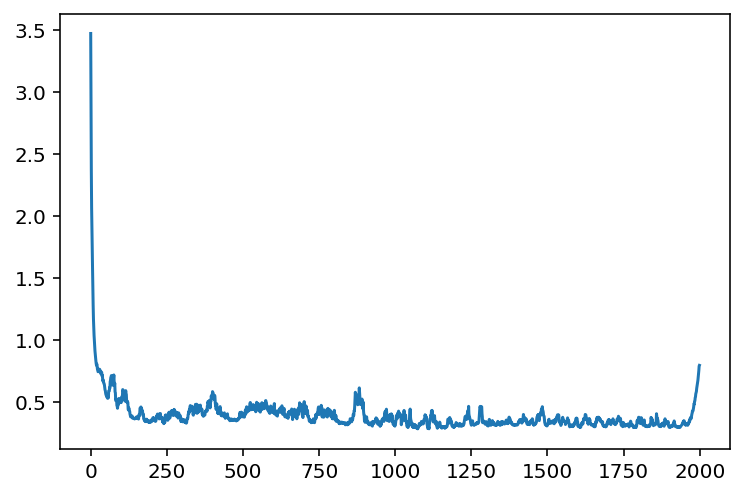

In [56]:
plt.plot(error.mean(axis=0))

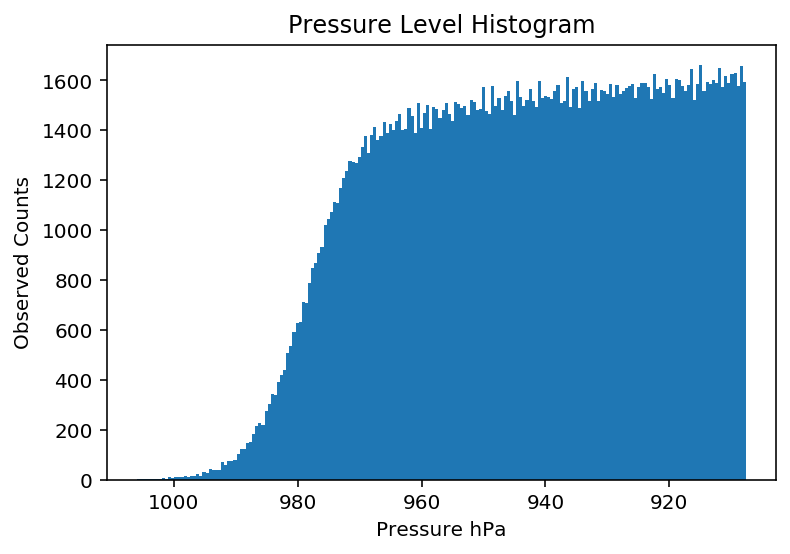

In [93]:
histo = plt.hist(pressures.ravel(), bins[1800:])
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts')
plt.title('Pressure Level Histogram');

In [127]:
np.set_printoptions(suppress=True)
histo[0]

array([6634., 6634., 6822., 6668., 6686., 6689., 6672., 6704., 6652.,
       6576., 6738., 6622., 6670., 6621., 6722., 6470., 6714., 6648.,
       6553., 6624., 6603., 6646., 6531., 6648., 6619., 6567., 6504.,
       6622., 6591., 6519., 6494., 6537., 6675., 6480., 6502., 6492.,
       6592., 6446., 6528., 6585., 6473., 6479., 6533., 6399., 6502.,
       6473., 6471., 6560., 6468., 6382., 6510., 6478., 6440., 6385.,
       6467., 6566., 6306., 6505., 6494., 6259., 6606., 6305., 6400.,
       6473., 6392., 6373., 6369., 6417., 6333., 6282., 6364., 6443.,
       6231., 6324., 6383., 6361., 6226., 6324., 6348., 6249., 6336.,
       6230., 6206., 6371., 6160., 6318., 6251., 6160., 6278., 6239.,
       6180., 6137., 6173., 6204., 6203., 6016., 6255., 6028., 6127.,
       6006., 6177., 5975., 6010., 6034., 6004., 5879., 6027., 5863.,
       5911., 5860., 5750., 5771., 5753., 5500., 5600., 5456., 5431.,
       5290., 5167., 5010., 5058., 4761., 4624., 4551., 4262., 4096.,
       3946., 3730.,

In [ ]:
def compute_differences(nnet, X, T):
    if len(X.shape) > 2:
        pressure = X[index,:,PRESSURE]
    else:
        pressure = X[index,:SONDE_PROFILE_DIMS]

    Y = nnet.use(X)

    
compute_differences(nnet, Xtest, Ttest)

## Convolutional AutoEncoder

In [72]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [73]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], (8, 16, 24), [(10, 1)]*3,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 15, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.64830
epoch: 5, loss: 0.58896
epoch: 10, loss: 0.58886
epoch: 14, loss: 0.58883
finished!


ConvolutionalAutoEncoder((2000, 3), (8, 16, 24), [(10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.58883 in 443.3226 seconds.

In [74]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 8)           248       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 16)          1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 24)           3864      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 24)           0     

In [107]:
bins = np.linspace(0, 1100, 10)

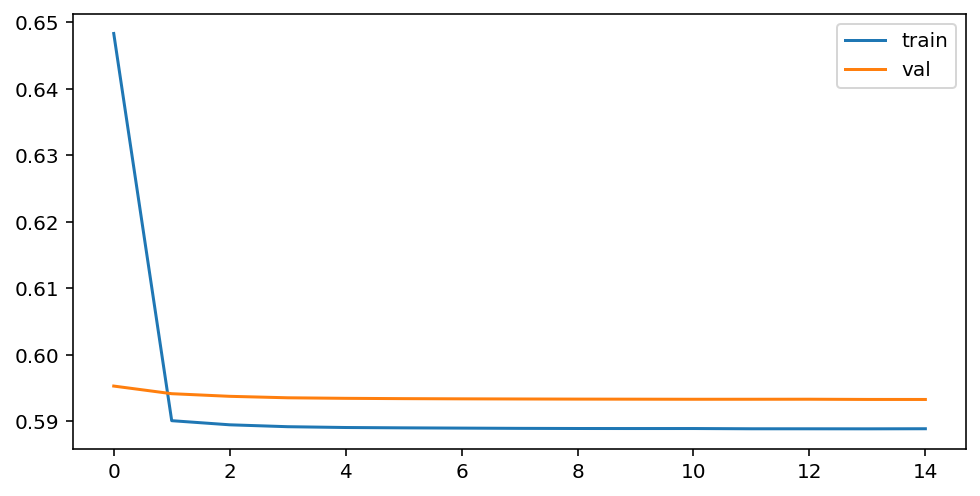

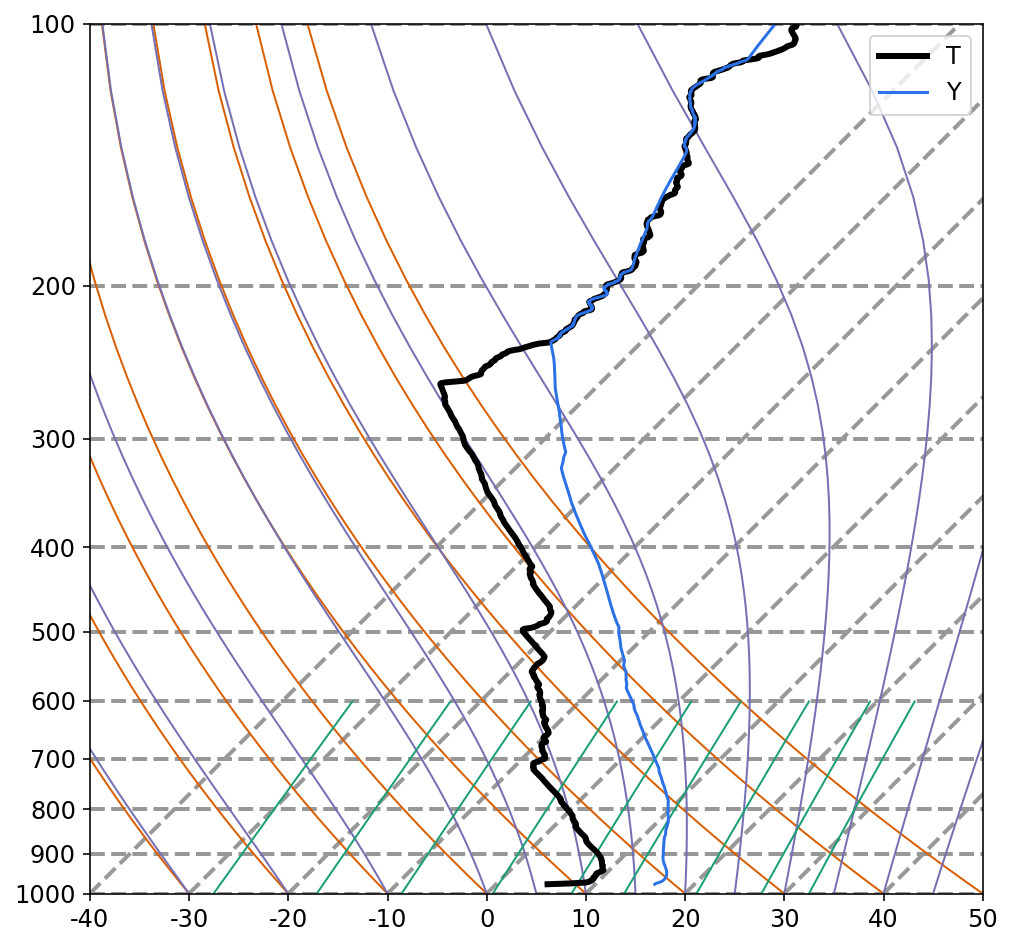

In [76]:
plot_results(nnet, Xtest, Ttest, index=1)

## Operational

In [77]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      profiles:  1.1 GiB
                         files: 10.9 MiB
                      is_valid: 26.7 KiB
                 FloatProgress:  1.0 KiB
                           _i8:  926.0 B
                          _i24:  815.0 B
                          _i27:  810.0 B
                          _i29:  807.0 B
                          _i30:  807.0 B
                          _i32:  798.0 B


## Density

In [142]:
files = np.array(glob(join(vol, '2001/sgpsondewnpnC1.b1.*.cdf')))

pressures = np.array([])

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        pressures = np.append(pressures, xar.pres.values)    
    xar.close()    
e = time.time() - s

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

time: 11.227, avg: 0.011 seconds


In [143]:
pressures.shape

(2647636,)

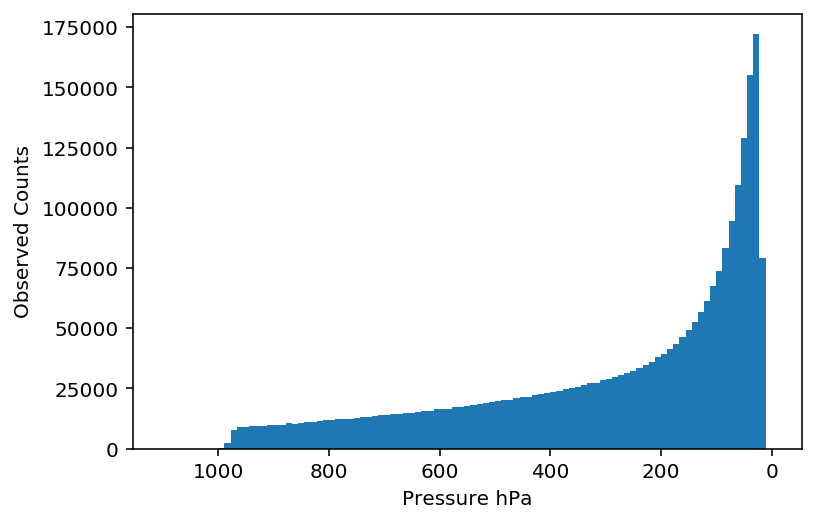

In [154]:
plt.hist(pressures, bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');

In [161]:
Xtrain[:,:,PRESSURE].ravel().shape

(39342000,)

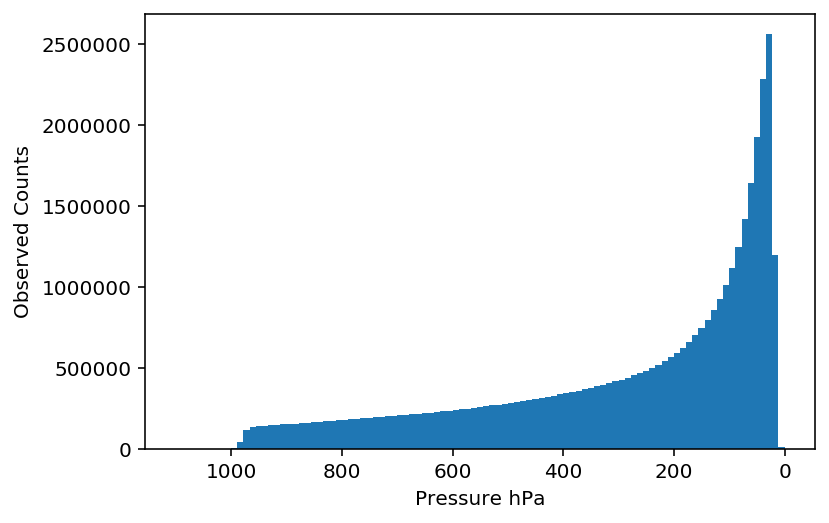

In [160]:
plt.hist(Xtrain[:,:,PRESSURE].ravel(), bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');